## Predicting Stock Direction with Regularized Logistic Regression
The main goal of this notebook is to write a code that predicts stock "Direction" tomorrow. Direction means basically if the price goes up (d=1) or down (d=0). I used the ticker ENI.MI.


In [26]:
#Importing Packages

from pandas_datareader.data import DataReader

from datetime import date, datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import pickle
import sys


pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [27]:
sys.version

'3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]'

In [2]:
## Useful functions

def data_loader(ticker, cols, start, end, data_source):
    stock_data = DataReader(ticker, data_source, start, end)
    stock_data = stock_data[cols]
    return stock_data


def create_target(stock_data,l):
    
    stock_data['Return_Today'] = stock_data['Adj Close'].pct_change()*100
    stock_data['Return_Tomorrow'] = stock_data['Return_Today'].shift(-1)
    
    cond_zero = lambda x: x==0.0
    close_zero_obs = stock_data['Return_Tomorrow'].apply(cond_zero).sum()
    tot_obs = stock_data['Return_Tomorrow'].count()
    print(f'Percentage of returns equal to zero: {"{:.2%}".format(close_zero_obs/tot_obs)}')
    
    stock_data = stock_data.loc[stock_data['Return_Tomorrow']!=0]
          
    cond_almost_zero = lambda x: -l<x<l
    almost_zero_obs = stock_data['Return_Tomorrow'].apply(cond_almost_zero).sum()
    print(f'Percentage of returns almost zero grouped with positive and negative: {"{:.2%}".format(almost_zero_obs/tot_obs)}.')
    
          
    #Calculating direction
    stock_data['Direction'] = (stock_data['Return_Tomorrow'] > 0).astype(int)
    stock_data.dropna(inplace=True) #last row
    
    return stock_data
          
          
def calc_intraday_indicators(stock_data):
    stock_data['O-C'] = stock_data['Open'] - stock_data['Close'] #Open minus Close
    stock_data['H-L'] = stock_data['High'] - stock_data['Low']  #High minus Low
    return stock_data


def calc_MAs(stock_data):
    #MA
    for i in [5,12,20]:
        #SMA
        stock_data[f'SMA_{i}d'] = stock_data['Adj Close'].rolling(i).mean()

        #EWMA
        stock_data[f'EWMA_{i}d'] = stock_data['Adj Close'].ewm(span=i).mean()
    return stock_data

def calc_momentum(stock_data):
    #Momentum
    for i in range(2,11,1):    
        stock_data[f'Momentum{i}d'] = stock_data['Adj Close'].diff(i)
    return stock_data
    
def calc_past_returns(stock_data):
    #Past Returns
    for j in range(1,31):
            stock_data[f'Return_Today_Lag{j}'] = stock_data['Return_Today'].shift(j)
    return stock_data

def calc_sign(stock_data):
    stock_data['Sign']=np.log(stock_data['Adj Close']).diff()
    return stock_data

          
          
          
def prepare_data(stock_data, features, scaler_obj, cut_off, h_tuning=False, ts=None):
    
    X=stock_data[features]
    y=stock_data[target]

    
    X_pre=X[X.index<=cut_off]
    y_pre=y[y.index<=cut_off] 

    if h_tuning:
        X_train, X_test, y_train, y_test = train_test_split(X_pre,y_pre, test_size = ts, shuffle = False)
    else:
        X_post=X[X.index>cut_off]
        y_post=y[y.index>cut_off] 
        
        X_train, X_test, y_train, y_test = X_pre, X_post, y_pre, y_post 
    
    y_test.values.ravel()

    #Scaling the variables
    sc = scaler_obj
    sc.fit(X_train)

    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    
    return sc, X_train_std, X_test_std, y_train, y_test

## Loading data
In this step data is loaded from Yahoo Finance. Dataframe is stored in a .csv file for avalaibility purposes and there is no need to connect to the API each time code is needed to be run.

In [3]:
#Loading data from Yahoo Finance
ticker = 'ENI.MI'
cols = ['Open','High', 'Low', 'Close', 'Adj Close']


start = date(2018, 4, 24) 
end = date(2022, 5, 24) 
data_source = 'yahoo'

stock_data= data_loader(ticker, cols, start, end, data_source)



Here I inspect the first 5 lines to have an idea of the loaded dataset.

In [4]:
#Visualize data
stock_data.head(5)

,Open,High,Low,Close,Adj Close
Date,,,,,
2018-04-24,16.068001,16.180000,15.962000,16.028000,12.212487
2018-04-25,15.988000,16.011999,15.734000,15.850000,12.076860
2018-04-26,15.918000,16.170000,15.876000,16.170000,12.320683
2018-04-27,16.077999,16.158001,15.940000,16.158001,12.311541
2018-04-30,16.158001,16.200001,16.006001,16.200001,12.343542


As showed below, the loaded dataframe does not contains NaN values.

In [5]:
display(stock_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1037 entries, 2018-04-24 to 2022-05-24
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1037 non-null   float64
 1   High       1037 non-null   float64
 2   Low        1037 non-null   float64
 3   Close      1037 non-null   float64
 4   Adj Close  1037 non-null   float64
dtypes: float64(5)
memory usage: 48.6 KB


None

Here I have a look at descriptive statistics. 

In [6]:
stock_data.describe()

,Open,High,Low,Close,Adj Close
count,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000
mean,12.221926,12.345372,12.093071,12.215928,10.557766
std,2.859210,2.856127,2.858013,2.855155,2.133314
min,5.877000,6.013000,5.726000,5.885000,5.350848
25%,9.827000,9.957000,9.733000,9.876000,9.076869
50%,13.142000,13.312000,12.972000,13.104000,11.492860
75%,14.404000,14.498000,14.290000,14.358000,12.208847
max,16.790001,16.889999,16.618000,16.764000,14.080187


Using a boxplot is useful to understand if the dataframe contains potential outliers. Fortunately, no outliers are spotted from graphical analysis.

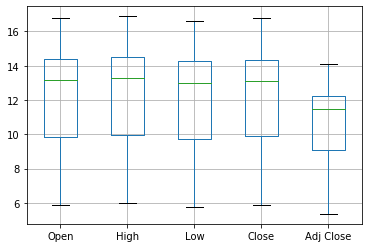

In [7]:
#Checking for outliers
stock_data.boxplot()

Plotting the Adjusted price. Adjusted Close Price gives the adjusted values of closing price, hence the fair picture in case of off-beat events like splits and dividends. Using close price instead of adj close price may provide unrealistic and false values of metrics like returns, which could generate false signals. We see here huge drop of the asset during the Covid outbreak.

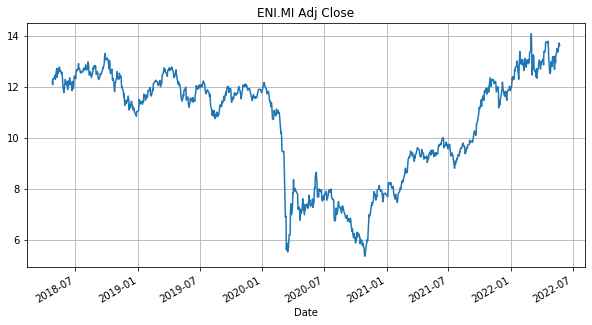

In [8]:
stock_data['Adj Close'].plot(figsize=[10,5],grid=True, title= ticker + ' Adj Close')

## Target Variable - Direction
Dependent variable is a 0-1 Flag indicating if the stock return tomorrow will be positive (1) or negative (0). I started calculating one day ahead linear returns in order to manage close to zero cases. Then some analysis on target variable is performed.

In [9]:
#Calculating linear returns
stock_data = create_target(stock_data, l=0.002)

Percentage of returns equal to zero: 0.48%
Percentage of returns almost zero grouped with positive and negative: 0.00%.


C:\Users\BU02492\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\BU02492\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Class are not highly inbalanced which is helpful as I do not need to resort to oversampling techniques. See below.

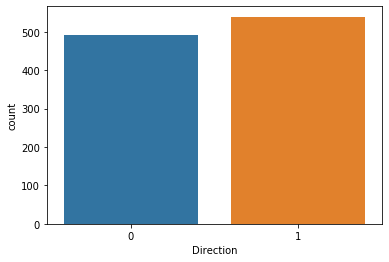

In [10]:
#visualise the target variable
sns.countplot(x ='Direction', data = stock_data)
plt.show()

## Independent Variables
In the following sections feature engineering is performed in order to add proposed variables and lags: <br>

- Open – Close <br> 
- High – Low  <br>
- Sign = $\ln \frac{P_t}{P_{t-1}}$ <br>
- $R_t, R_{t-1},… P_t$ <br>
- Momentum $Pt – P_{t-k}$ (price change period k days) <br>
- Exponential Moving avg: $EMA_t = EMA_{t-1} + A(P_t -EMA_{t-1})$ <br>
- Moving avg: $SMA_i = \frac{1}{n} \sum_{i=0}^{n-1} P_{t-i}$ <br>          


In [11]:
#Intraday indicators
stock_data = calc_intraday_indicators(stock_data)

For what concerns moving averages, lags used are 5,12,20. Those are typically used as short term technical indicators both for SMA and EWMA. I decided not to abuse with lags as they result to be much correlated

In [12]:
stock_data = calc_MAs(stock_data)
stock_data = calc_momentum(stock_data)
stock_data = calc_past_returns(stock_data)
stock_data = calc_sign(stock_data)


In [13]:
#Building lists in order to check correlation with the return 1day ahead
returns_cols = [c for c in stock_data.columns if 'Return' in c] 
ma = [c for c in stock_data.columns if 'MA_'in c or 'Return_Tomorrow' in c]
v = [c for c in stock_data.columns if '-'in c or 'Return_Tomorrow' in c]
mom = [c for c in stock_data.columns if 'Momentum'in c or 'Return_Tomorrow' in c]
sign = [c for c in stock_data.columns if 'Sign'in c or 'Return_Tomorrow' in c]
sign = [c for c in stock_data.columns if 'Volume'in c or 'Return_Tomorrow' in c]


At first sight, the variables seems not to be much correlated with the one day ahead return. Anyway I'll keep them trying to see how they affect direction

In [14]:
print('Correlation of engineered variables with Return the day after:')
print('\n')

print('Lagged Returns:')
display(stock_data[returns_cols].corr()[1:2].T)
print('\n')

print('Moving Averages:')
display(stock_data[ma].corr()[:1].T)
print('\n')

print('Intraday indicators:')
display(stock_data[v].corr()[:1].T)
print('\n')

print('Momentum:')
display(stock_data[mom].corr()[:1].T)
print('\n')

print('Sign:')
display(stock_data[sign].corr()[:1].T)
print('\n')


Correlation of engineered variables with Return the day after:


Lagged Returns:


,Return_Tomorrow
Return_Today,0.015845
Return_Tomorrow,1.000000
Return_Today_Lag1,0.004228
Return_Today_Lag2,0.049204
Return_Today_Lag3,0.044481
Return_Today_Lag4,0.126977
Return_Today_Lag5,0.004728
Return_Today_Lag6,0.027594
Return_Today_Lag7,-0.106450
Return_Today_Lag8,-0.041767




Moving Averages:


,Return_Tomorrow
Return_Tomorrow,1.000000
SMA_5d,-0.048056
EWMA_5d,-0.047644
SMA_12d,-0.055762
EWMA_12d,-0.050302
SMA_20d,-0.051119
EWMA_20d,-0.049949




Intraday indicators:


,Return_Tomorrow
Return_Tomorrow,1.000000
O-C,-0.074975
H-L,0.022070




Momentum:


,Return_Tomorrow
Return_Tomorrow,1.000000
Momentum2d,-0.001811
Momentum3d,0.029434
Momentum4d,0.042081
Momentum5d,0.086971
Momentum6d,0.081794
Momentum7d,0.078949
Momentum8d,0.049225
Momentum9d,0.034637
Momentum10d,0.048908




Sign:


,Return_Tomorrow
Return_Tomorrow,1.0


Here the fastest and the slowest EMA/SMA used are plotted. The graph shows only the last year.

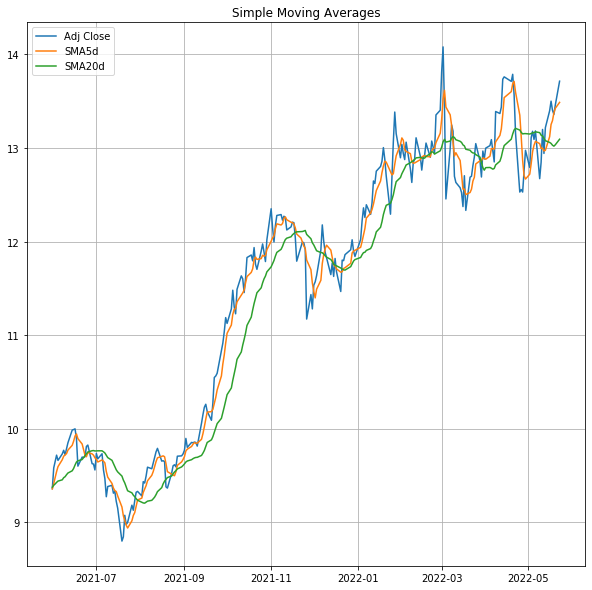

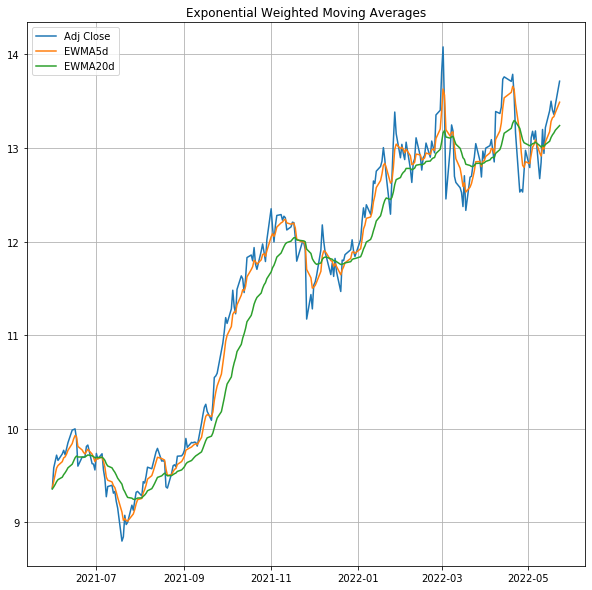

In [15]:
range_x = 252 #last year


plt.figure(figsize=[10,10])
plt.grid()
plt.plot(stock_data['Adj Close'][-range_x:], label='Adj Close')
plt.plot(stock_data['SMA_5d'][-range_x:], label='SMA5d')
plt.plot(stock_data['SMA_20d'][-range_x:], label='SMA20d')
plt.legend()
plt.title('Simple Moving Averages')
plt.show()

plt.figure(figsize=[10,10])
plt.grid()
plt.title('Exponential Weighted Moving Averages')
plt.plot(stock_data['Adj Close'][-range_x:], label='Adj Close')
plt.plot(stock_data['EWMA_5d'][-range_x:], label='EWMA5d')
plt.plot(stock_data['EWMA_20d'][-range_x:], label='EWMA20d')


plt.legend()
plt.show()

In [16]:
stock_data = stock_data.dropna() #dropping na rows after lag calculations

Independent variables seems non to be much correlated with the future 1day return. In the following we will see how the variables affect direction.

## Features Analysis
In this step some analysis to understand variables importance is performed. First, I analyze empirically the results in order to understand which can be the variables that affects the direction of the stock on the next day.


In [17]:
#target variables
target = ['Direction']

#list of features
features = list(set(stock_data.columns) - {'High','Low','Open','Close','Adj Close','Return_Tomorrow','Return_Today','Direction'})

print('Initial_list:')
print(features)
print('\n')
print(f'Initial number of the variables: {len(features)}')


Initial_list:
['Return_Today_Lag10', 'Momentum3d', 'Momentum8d', 'Return_Today_Lag19', 'Return_Today_Lag3', 'Return_Today_Lag16', 'Return_Today_Lag24', 'Return_Today_Lag28', 'Return_Today_Lag1', 'Momentum9d', 'Return_Today_Lag6', 'Momentum10d', 'Return_Today_Lag8', 'SMA_20d', 'Momentum5d', 'EWMA_12d', 'Return_Today_Lag5', 'Momentum2d', 'SMA_5d', 'Return_Today_Lag4', 'O-C', 'Momentum7d', 'H-L', 'EWMA_20d', 'Return_Today_Lag30', 'Return_Today_Lag9', 'Return_Today_Lag26', 'Return_Today_Lag21', 'Return_Today_Lag12', 'Return_Today_Lag18', 'Return_Today_Lag23', 'EWMA_5d', 'Return_Today_Lag11', 'Sign', 'Return_Today_Lag22', 'Return_Today_Lag29', 'SMA_12d', 'Return_Today_Lag7', 'Return_Today_Lag27', 'Momentum4d', 'Return_Today_Lag14', 'Return_Today_Lag13', 'Return_Today_Lag15', 'Return_Today_Lag2', 'Momentum6d', 'Return_Today_Lag25', 'Return_Today_Lag20', 'Return_Today_Lag17']


Initial number of the variables: 48


Here I calculate the categorical means with respect to the binary response classes. If the mean of a variable changes significatively from one binary class to another I may assume that it will be relevant to explain the dependent variable.
Almost all variables have different means in each binary group therefore I will keep all of them and I'll try to reduce overfitting and multicollinearity through regularization techniques.

In [18]:
#Categorical means by class for each independent variable
df_means = stock_data[target + features].groupby(target)[features].mean()
#display(df_means.T)

#Calculate percentage difference of means in the two binary classes. 
df_change_mean = df_means.T.apply(lambda x: x.pct_change(),axis=1)[[1]].T
df_change_mean.rename(index={1: '%Change of Mean for binary class'}, inplace=True)
df_change_mean = df_change_mean.applymap("{:,.2%}".format).T

df_means = pd.concat([df_means.T, df_change_mean],axis=1)

display(df_means)


Direction,0,1,%Change of Mean for binary class
Return_Today_Lag10,-0.037759,0.067696,-279.28%
Momentum3d,0.019922,-0.010081,-150.60%
Momentum8d,0.009176,0.011815,28.77%
Return_Today_Lag19,0.010540,0.020784,97.18%
Return_Today_Lag3,-0.015398,0.067173,-536.24%
Return_Today_Lag16,0.012713,0.021009,65.26%
Return_Today_Lag24,0.004230,0.046469,998.54%
Return_Today_Lag28,0.066657,-0.015602,-123.41%
Return_Today_Lag1,0.133544,-0.065655,-149.16%
Momentum9d,0.020870,0.003453,-83.45%


From previous correlation analysis and this last result It seems that predictors contributes equally to predict the dependent variable. In particular The categorical mean for binary classes changes significatively for some of them.

## Checking correlations among regressors

In [19]:
corr_matr = stock_data[features].corr()

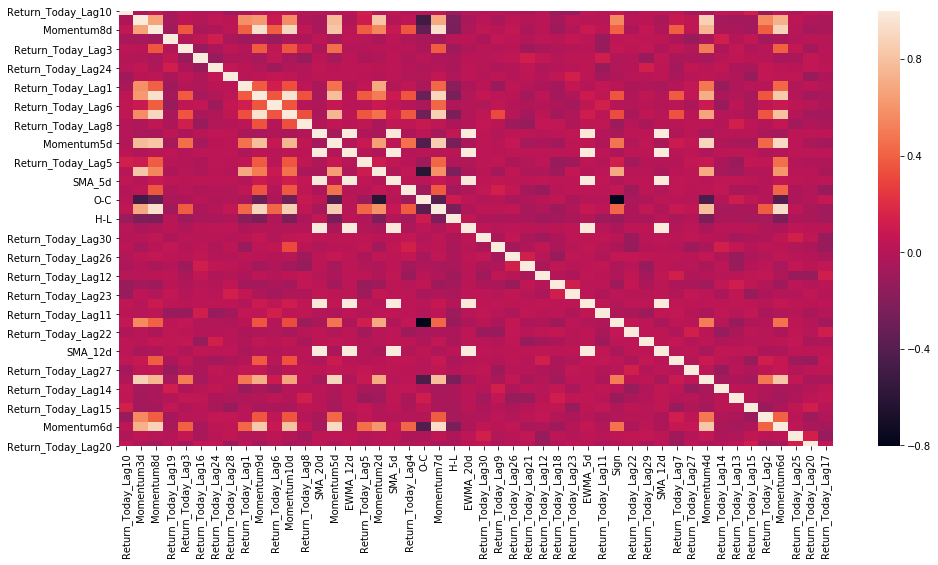

In [20]:
plt.figure(figsize=(16,8))
sns.heatmap(corr_matr)

In [21]:
#calculate Variance Inflation Factor
vif_scores = pd.DataFrame() 
vif_scores["Regressor"] = stock_data[features].columns 
  
# calculating VIF for each feature 
vif_scores["VIF"] = [
    variance_inflation_factor(stock_data[features].values, i) for i in range(len(stock_data[features].columns))] 
  
vif_scores.set_index('Regressor',inplace=True)
vif_scores.sort_values(by='VIF').applymap("{:,.2f}".format)




,VIF
Regressor,
Return_Today_Lag30,1.23
Return_Today_Lag29,1.26
Return_Today_Lag28,1.30
Return_Today_Lag27,1.35
Return_Today_Lag26,1.37
Return_Today_Lag25,1.42
Return_Today_Lag24,1.53
Return_Today_Lag23,1.74
Return_Today_Lag16,1.97


 From Variance Inflation Factor analysis and from the Heatmap, clearly there is high correlation between some of the regressors (specially MA and Momentum).
This problem will be faced keeping all the variables and using regularization techniques.

## Model Estimation


Before using Ridge/LASSO techniques I need to standardize the features.
LASSO and Ridge regression put constraints on the size of the coefficients associated to each variable. However, this value will depend on the magnitude of each variable. Basically, If variables are not scaled, it means that the shrinkage effect will not be 'fair'(homogeneous across variables).  Standardization will be performed separately for test/train/validation set as I do not want to introduce "future' information when training or tuning parameters.  

In [22]:
#Used variables
display(pd.Series(features))

0     Return_Today_Lag10
1             Momentum3d
2             Momentum8d
3     Return_Today_Lag19
4      Return_Today_Lag3
5     Return_Today_Lag16
6     Return_Today_Lag24
7     Return_Today_Lag28
8      Return_Today_Lag1
9             Momentum9d
10     Return_Today_Lag6
11           Momentum10d
12     Return_Today_Lag8
13               SMA_20d
14            Momentum5d
15              EWMA_12d
16     Return_Today_Lag5
17            Momentum2d
18                SMA_5d
19     Return_Today_Lag4
20                   O-C
21            Momentum7d
22                   H-L
23              EWMA_20d
24    Return_Today_Lag30
25     Return_Today_Lag9
26    Return_Today_Lag26
27    Return_Today_Lag21
28    Return_Today_Lag12
29    Return_Today_Lag18
30    Return_Today_Lag23
31               EWMA_5d
32    Return_Today_Lag11
33                  Sign
34    Return_Today_Lag22
35    Return_Today_Lag29
36               SMA_12d
37     Return_Today_Lag7
38    Return_Today_Lag27
39            Momentum4d


## Validating Models

Here I perform a very simple validation procedure. I will not use k- fold CV approach o random splits of the set since I want to respect temporal frames as we are dealing with time series.
In particular:

- Last year is the test set: 2021-5-24 to 2021-5-22
- The time window before 2021-5-24 is split with an 80%-20% logic (non random) to obtain training and validation set
- AUC will be used as measure of goodness

In [23]:
cut_off = datetime(2021, 5, 24)

scaler = StandardScaler()
sc, X_train_std, X_test_std, y_train, y_test = prepare_data(
    stock_data, features, scaler, cut_off, h_tuning=True, ts=0.2)


#Table of variables and scaling factors
print('Table of Features with details on standardization performed')
display(pd.DataFrame({'Features':features, 'mean':sc.mean_,'var':sc.var_, 'method': '(x - mean)/sqrt(var)' }))

Table of Features with details on standardization performed


,Features,mean,var,method
0,Return_Today_Lag10,-0.106351,4.653936,(x - mean)/sqrt(var)
1,Momentum3d,-0.030992,0.106255,(x - mean)/sqrt(var)
2,Momentum8d,-0.080078,0.353492,(x - mean)/sqrt(var)
3,Return_Today_Lag19,-0.096213,4.602871,(x - mean)/sqrt(var)
4,Return_Today_Lag3,-0.093384,4.695169,(x - mean)/sqrt(var)
5,Return_Today_Lag16,-0.103140,4.611647,(x - mean)/sqrt(var)
6,Return_Today_Lag24,-0.083884,4.591660,(x - mean)/sqrt(var)
7,Return_Today_Lag28,-0.083381,4.587048,(x - mean)/sqrt(var)
8,Return_Today_Lag1,-0.098642,4.722341,(x - mean)/sqrt(var)
9,Momentum9d,-0.089698,0.402011,(x - mean)/sqrt(var)


In the following code I perform hyperparameter tuning. In this case the parameter to be tuned is $c=\frac{1}{\lambda}$. The idea is to find the best combination of $c$ and LASSO or Ridge regression in term of AUC. AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. In few words, higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1

C:\Users\BU02492\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\BU02492\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


_________________Results for c=1000 regularization parameter_________________

Confusion Matrix for LASSO:


,0,1
0,45,12
1,17,75


Confusion Matrix for Ridge:


,0,1
0,45,12
1,17,75


C: 1000 Accuracy LASSO: 0.8054 Accuracy Ridge: 0.8054


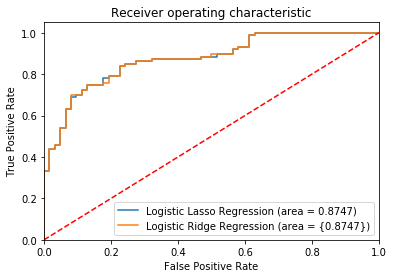

C:\Users\BU02492\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\BU02492\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


_________________Results for c=10 regularization parameter_________________

Confusion Matrix for LASSO:


,0,1
0,44,14
1,18,73


Confusion Matrix for Ridge:


,0,1
0,42,13
1,20,74


C: 10 Accuracy LASSO: 0.7852 Accuracy Ridge: 0.7785


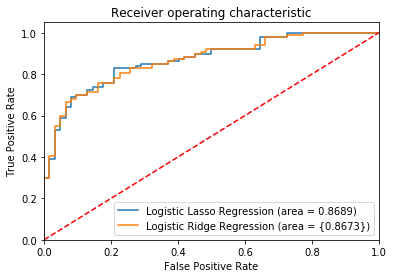

C:\Users\BU02492\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\BU02492\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


_________________Results for c=1 regularization parameter_________________

Confusion Matrix for LASSO:


,0,1
0,43,13
1,19,74


Confusion Matrix for Ridge:


,0,1
0,42,13
1,20,74


C: 1 Accuracy LASSO: 0.7852 Accuracy Ridge: 0.7785


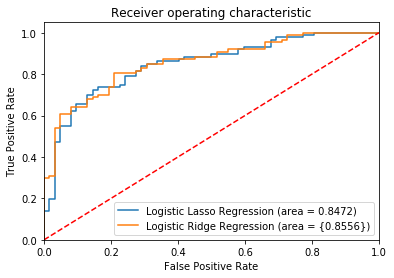

_________________Results for c=0.1 regularization parameter_________________

Confusion Matrix for LASSO:


C:\Users\BU02492\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\BU02492\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,0,1
0,19,4
1,43,83


Confusion Matrix for Ridge:


,0,1
0,39,13
1,23,74


C: 0.1 Accuracy LASSO: 0.6846 Accuracy Ridge: 0.7584


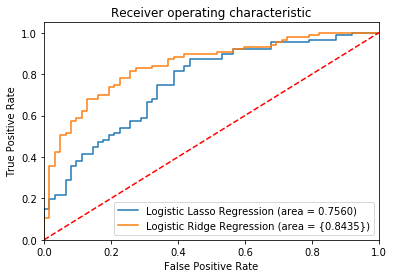

_________________Results for c=0.01 regularization parameter_________________

Confusion Matrix for LASSO:


C:\Users\BU02492\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\BU02492\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,0,1
0,0,0
1,62,87


Confusion Matrix for Ridge:


,0,1
0,19,4
1,43,83


C: 0.01 Accuracy LASSO: 0.5839 Accuracy Ridge: 0.6846


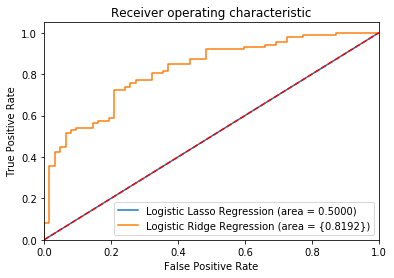

_________________Results for c=0.0001 regularization parameter_________________

Confusion Matrix for LASSO:


C:\Users\BU02492\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\BU02492\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,0,1
0,0,0
1,62,87


Confusion Matrix for Ridge:


,0,1
0,0,0
1,62,87


C: 0.0001 Accuracy LASSO: 0.5839 Accuracy Ridge: 0.5839


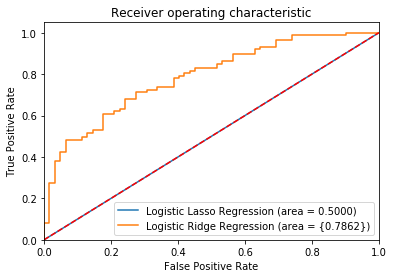

In [24]:

for c in [1000, 10, 1,0.1, 0.01, 0.0001]:

    lasso = LogisticRegression(penalty= 'l1', C=c, random_state=42, max_iter=10000, solver='saga')
    lasso.fit(X_test_std,y_test)

    ridge = LogisticRegression(penalty= 'l2', C=c, random_state=42, max_iter=10000, solver='saga')
    ridge.fit(X_test_std,y_test)

    y_pred_lasso = lasso.predict(X_test_std)           
    y_pred_ridge = ridge.predict(X_test_std)
    
    accuracy_lasso = round(accuracy_score(y_test, y_pred_lasso),4)
    accuracy_ridge = round(accuracy_score(y_test, y_pred_ridge),4)
    
    
    print(f'_________________Results for c={c} regularization parameter_________________\n')
    print('Confusion Matrix for LASSO:')
    display(pd.DataFrame(confusion_matrix(y_pred_lasso,y_test)))
    print('Confusion Matrix for Ridge:')
    display(pd.DataFrame(confusion_matrix(y_pred_ridge,y_test)))
    print('C:', c, 'Accuracy LASSO:', accuracy_lasso, 'Accuracy Ridge:', accuracy_ridge)
    
    #Plot
    logit_roc_auc_lasso = roc_auc_score(y_test, lasso.predict_proba(X_test_std)[:,1])
    logit_roc_auc_ridge = roc_auc_score(y_test, ridge.predict_proba(X_test_std)[:,1])
    
    fpr_lasso, tpr_lasso, _ = roc_curve(y_test, lasso.predict_proba(X_test_std)[:,1])
    fpr_ridge, tpr_ridge, _ = roc_curve(y_test, ridge.predict_proba(X_test_std)[:,1])
    
    plt.figure()
    
    plt.plot(fpr_lasso, tpr_lasso, label='Logistic Lasso Regression (area = %0.4f)' % logit_roc_auc_lasso)
    plt.plot(fpr_ridge, tpr_ridge, label='Logistic Ridge Regression (area = {%0.4f})' % logit_roc_auc_ridge)
    
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    plt.show()

    


## Testing the best model
The best model is Ridge with c=1000. I will train this model using data up to 2021-05-24 and I will make prediction on last year data.

C:\Users\BU02492\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


_________________Results for c=0.0001 regularization parameter_________________

Confusion Matrix for LASSO:


,0,1
0,51,34
1,59,112


C: 0.0001 Accuracy LASSO: 0.6367


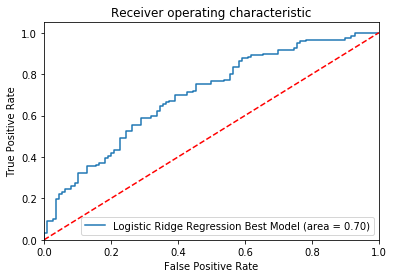

In [25]:
#Retraining the model with best parameters

best_penalty = 'l2'
best_c = 1000


cut_off = datetime(2021, 5, 24)
scaler = StandardScaler()
sc, X_train_std, X_test_std, y_train, y_test = prepare_data(
    stock_data, features, scaler, cut_off, h_tuning=False, ts=None)


best_m = LogisticRegression(penalty= best_penalty, C=best_c, random_state=42, max_iter=10000, solver='saga')
best_m.fit(X_test_std,y_test)


# save the model to disk
filename = 'finalized_model_bitcoin.sav'
pickle.dump(best_m, open(filename, 'wb'))


y_pred_best_m = best_m.predict(X_test_std)           

accuracy_best_m= round(accuracy_score(y_test, y_pred_best_m),4)


print(f'_________________Results for c={c} regularization parameter_________________\n')

print('Confusion Matrix for LASSO:')
display(pd.DataFrame(confusion_matrix(y_pred_best_m,y_test)))

print('C:', c, 'Accuracy LASSO:', accuracy_best_m)
logit_roc_auc_best_m = roc_auc_score(y_test, best_m.predict_proba(X_test_std)[:,1])

fpr_lasso, tpr_lasso, _ = roc_curve(y_test, best_m.predict_proba(X_test_std)[:,1])


plt.figure()

plt.plot(fpr_lasso, tpr_lasso, label='Logistic Ridge Regression Best Model (area = %0.2f)' % logit_roc_auc_best_m)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()


## Conclusion
In this particular case there is not much difference in using Ridge or LASSO regression. They both lead to an acceptable level of discrimination for stock direction using the best regularization parameters.

More in detail, Ridge regularization works well when most predictors impact the response. In our case, as shown by correlations of the independent variable with tomorrow returns, it does not exist a specific set of variables that affects the target more than others. As I decrease the c, the lambda coefficient $\lambda = \frac{1}{c}$ increases. Therefore the shrinkage effect of lasso increases forcing some coefficients to zero (variable selection) and increasing the bias of the l1 model. 

Finally the chose is the Ridge Regression with $c=1000$.
Using 80%-20% train-validation split logic the best model has been retrained and tested on the last year. 
The model, when facing new information, has shown ability of correctly discriminating positive or negative returns for 70% of the observations.